# 7. Advanced Deep Learning Best Practices

### Callbacks

When training a model, there are many things you cannot predict from the start. For example you cannot predict the number of epochs needed to get an optimal validation loss. Typically, you train for the specified number of epochs, then select the optimal number of epochs to train for and train again. This approach is wasteful.

A much better way to handle this is to stop training when you realise the validation loss is no longer improving. This can be achieved using a Keras callback. A <b>callback</b> is an object that is passed in the model in the call to `fit()` and is called by the model at various points during training. It has access to all the availebl data about the state of the model and can take various actions: interrupt training, save model, load weight sets etc. Some common callbacks are:

- `callbacks.ModelCheckpoint` - to save the current weights of the model at different points during training
- `callbacks.EarlyStopping` - interrupt training when the validation loss is no longer improving
- `callbacks.LearningRateScheduler` - dynamically adjusting the value of certain parameters during training
- `callbacks.ReduceLROnPlateau` -
- `callbacks.CSVLogger` - logging training & validation metrics during training, or visualising the representations learned by the model as they are updated

In [1]:
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras

In [2]:
# Ingestion & Preprocessing
###########################
sc = StandardScaler()
(train_data, y_train), (test_data, y_test) = keras.datasets.boston_housing.load_data()
x_train, x_test = sc.fit_transform(train_data), sc.transform(test_data)
x_train__train, x_train__val, y_train__train, y_train__val = train_test_split(x_train, y_train, test_size=0.15,
                                                                             random_state=0)
NUM_FEATURES = x_train.shape[1:]

The `EarlyStopping` callback is used to interrupt training once a target metric being monitored has stopped improving for a fixed number of epochs. For example, to interrupt once the model starts overfitting, thus avoiding having to retrain the model for a smaller number of epochs. 

This is typically used with `ModelCheckpoint`, which lets you continuously save your model during training (and also save only the current best model so far, the version that has the best performance at the end of an epoch).

In [22]:
keras.backend.clear_session()
input_layer = keras.layers.Input(shape=NUM_FEATURES)
hidden_layer1 = keras.layers.Dense(30, activation='relu')(input_layer)
hidden_layer2 = keras.layers.Dense(30, activation='relu')(hidden_layer1)
concat_layer = keras.layers.Concatenate()([input_layer, hidden_layer2])
output_layer = keras.layers.Dense(1)(concat_layer)
m1 = keras.models.Model(inputs=[input_layer], outputs=output_layer)

m1_callbacks = [
    # interrupt training when there is no more improvement.
    # patience=2 means interrupt training when accuracy has stopped improving
    # for more than 2 epochs. mae MUST be in the compile step in the metrics
    keras.callbacks.EarlyStopping(monitor='mae', patience=2),
    # saves the current weights after every epoch
    # only overwrite the model file when val_loss has improved
    keras.callbacks.ModelCheckpoint('m1a.h5', monitor='val_loss', save_best_only=True)]
m1.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])

m1.fit(x_train, y_train,  epochs = 100, validation_data=(x_train__val, y_train__val), 
            callbacks=[m1_callbacks],)

Epoch 1/100
13/13 [==============================] - 0s 11ms/step - loss: 384.0434 - mae: 16.6905 - val_loss: 382.5454 - val_mae: 18.4230
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 202.3553 - mae: 11.9097 - val_loss: 106.2990 - val_mae: 8.5908
Epoch 3/100
13/13 [==============================] - 0s 7ms/step - loss: 33.5115 - mae: 4.1938 - val_loss: 118.6426 - val_mae: 9.4406
Epoch 4/100
13/13 [==============================] - 0s 7ms/step - loss: 37.0772 - mae: 4.5075 - val_loss: 32.6382 - val_mae: 4.5230
Epoch 5/100
13/13 [==============================] - 0s 7ms/step - loss: 28.0989 - mae: 3.9980 - val_loss: 14.5214 - val_mae: 2.9638
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 18.5885 - mae: 3.1224 - val_loss: 18.7011 - val_mae: 3.3571
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 14.6849 - mae: 2.7706 - val_loss: 27.5729 - val_mae: 4.1702
Epoch 8/100
13/13 [==============================] - 0s 8ms/

The `ReduceLROnPlateau` callback is used to reduce the learning rate when the validation loss has stopped improving. Reducing or increasing the learning rate in this case of a <u>loss plateau</u> is an effective strategy to get out of local minima during training.

In [23]:
keras.backend.clear_session()
input_layer = keras.layers.Input(shape=NUM_FEATURES)
hidden_layer1 = keras.layers.Dense(30, activation='relu')(input_layer)
hidden_layer2 = keras.layers.Dense(30, activation='relu')(hidden_layer1)
concat_layer = keras.layers.Concatenate()([input_layer, hidden_layer2])
output_layer = keras.layers.Dense(1)(concat_layer)
m2 = keras.models.Model(inputs=[input_layer], outputs=output_layer)

m2_callbacks = [
    # interrupt training when there is no more improvement.
    # patience=2 means interrupt training when accuracy has stopped improving
    # for more than 2 epochs. mae MUST be in the compile step in the metrics
    keras.callbacks.EarlyStopping(monitor='mae', patience=2),
    # saves the current weights after every epoch
    # only overwrite the model file when val_loss has improved
    keras.callbacks.ModelCheckpoint('m1a.h5', monitor='val_loss', save_best_only=True)]
m2.compile(optimizer='sgd', loss='mean_squared_error', metrics=['mae'])

m2.fit(x_train, y_train,  epochs = 100, validation_data=(x_train__val, y_train__val), 
            callbacks=[m2_callbacks],)

Epoch 1/100
13/13 [==============================] - 0s 11ms/step - loss: 437.6757 - mae: 17.6107 - val_loss: 208.3909 - val_mae: 12.3845
Epoch 2/100
13/13 [==============================] - 0s 6ms/step - loss: 198.7947 - mae: 11.0247 - val_loss: 81.5201 - val_mae: 6.8228
Epoch 3/100
13/13 [==============================] - 0s 5ms/step - loss: 41.6984 - mae: 4.5263 - val_loss: 16.7852 - val_mae: 3.3276
Epoch 4/100
13/13 [==============================] - 0s 5ms/step - loss: 18.3014 - mae: 3.0436 - val_loss: 31.4669 - val_mae: 4.4981
Epoch 5/100
13/13 [==============================] - 0s 4ms/step - loss: 20.6530 - mae: 3.3299 - val_loss: 17.5923 - val_mae: 3.2506
Epoch 6/100
13/13 [==============================] - 0s 7ms/step - loss: 14.5997 - mae: 2.6320 - val_loss: 10.6219 - val_mae: 2.4419
Epoch 7/100
13/13 [==============================] - 0s 7ms/step - loss: 10.5084 - mae: 2.3464 - val_loss: 23.2407 - val_mae: 3.7006
Epoch 8/100
13/13 [==============================] - 0s 6ms/st

If you need to take a specific action during training that is not covered by any of the built in callbacks, you can do so. Callbacks are implemented using `keras.callbacks.Callback`. You can then implement any number of the methods, called at the various points of training:
- `on_epoch_begin`, `on_epoch_end`
- `on_batch_begin`, `on_batch_end`
- `on_train_begin`, `on_train_end`

All these methods come with a `logs` argument, which is a dictionary containing information about the previous batch, epoch or training run. Additionally, the callback has access to the following:

- `self.model` the model instance from which the callback is being called
- `self.validation_data` the value of what was passed to `fit()` as validation data

In [27]:
class ActivationLogger(keras.callbacks.Callback):
    def set_model(self, model):
        self.model = model
        self.model_activations = keras.models.Model(model.input, 
                                                   [layer.output for layer in model.layers])
    
    def on_epoch_end(self, epoch, logs=None):
        if self.validation_data == None:
            raise RuntimeError('Requires validation data.')
        validation_sample = self.validation_data[0][0:1]
        activations = self.model_activations.predict(validation_sample)
        f = open('activations_at_epoch %s' % str(epoch) + '.npz', 'w')
        np.savex(f, activations)
        f.close()

With these tools, you can perform custom actions during different phases in the training step.

### Visualisation using TensorBoard
When performing experiments, it is useful to process experiment results. TensorBoard allows you to do so, to visually monitor everythign that goes on inside the model during training. You can visually monitor metrics, model architecture and also see gradients & activations.

In [4]:
def get_run_logdir(root_logdir):
    import time
    run_id = time.strftime("r_%Y%m%d_%H%M%S")
    return os.path.join(root_logdir, run_id)

root_logdirp = os.path.join(os.curdir, "logs")
run_logdir = get_run_logdir(root_logdirp)
print(run_logdir)

./logs/r_20200616_104206


In [5]:
m3_callbacks = [
    keras.callbacks.EarlyStopping(monitor='mae', patience=2),
    keras.callbacks.ModelCheckpoint('m3a.h5', monitor='val_loss', save_best_only=True),
    # Tensorboard callback and use it
    keras.callbacks.TensorBoard(run_logdir,
    histogram_freq=1, # records activation histogram every 1 epoch
    embeddings_freq=1 # records embedding data every 1 epoch
    )
]

# Ingestion
###########
VOCABULARY_SIZE = 2000
DOCUMENT_MAX_LENGTH = 125
(train_data, train_labels), (test_data, test_labels) = keras.datasets.imdb.load_data(num_words=VOCABULARY_SIZE)
x_train = keras.preprocessing.sequence.pad_sequences(train_data, maxlen=DOCUMENT_MAX_LENGTH)
x_test = keras.preprocessing.sequence.pad_sequences(test_data, maxlen=DOCUMENT_MAX_LENGTH)

keras.backend.clear_session()
model1 = keras.models.Sequential()
model1.add(keras.layers.Embedding(VOCABULARY_SIZE, 128, input_length=DOCUMENT_MAX_LENGTH))
model1.add(keras.layers.Conv1D(32, 7, activation='relu'))
model1.add(keras.layers.MaxPooling1D(5))
model1.add(keras.layers.Conv1D(32, 7, activation='relu'))
model1.add(keras.layers.GlobalMaxPooling1D())
model1.add(keras.layers.Dense(1))

# Compile
#########
model1.compile(optimizer=keras.optimizers.RMSprop(learning_rate=1e-4), 
               loss='binary_crossentropy',
               metrics=['acc'])
print(model1.summary())
# history1 = model1.fit(x_train, train_labels,
#                       epochs=10, 
#                       validation_split=0.2, callbacks=m3_callbacks)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 125, 128)          256000    
_________________________________________________________________
conv1d (Conv1D)              (None, 119, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 23, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 291,937
Trainable params: 291,937
Non-trainable params: 0
__________________________________________________

Finally, you can access the TensorBoard with `python -m tensorboard.main --logdir=r_20200601_122625/`

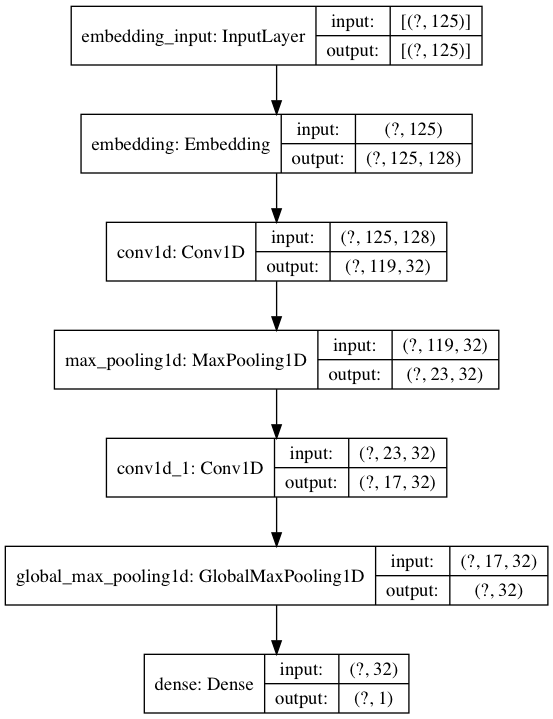

In [8]:
keras.utils.plot_model(model1, to_file='m1.png', show_shapes=True)